In [1]:
import pandas as pd
import glob
import os

In [2]:
from IPython.display import HTML, display
from cellphonedb.utils import db_releases_utils

display(HTML(db_releases_utils.get_remote_database_versions_html()['db_releases_html_table']))

Version,Release date,v4.1.0,2023-03-09


In [3]:
# -- Version of the databse
cpdb_version = 'v4.1.0'

# -- Path where the input files to generate the database are located
cpdb_target_dir = os.path.join('/QRISdata/Q6104/Charlotte', cpdb_version)

In [4]:
from cellphonedb.utils import db_utils

db_utils.download_database(cpdb_target_dir, cpdb_version)

Downloaded cellphonedb.zip into /QRISdata/Q6104/Charlotte/v4.1.0
Downloaded complex_input.csv into /QRISdata/Q6104/Charlotte/v4.1.0
Downloaded gene_input.csv into /QRISdata/Q6104/Charlotte/v4.1.0
Downloaded interaction_input.csv into /QRISdata/Q6104/Charlotte/v4.1.0
Downloaded protein_input.csv into /QRISdata/Q6104/Charlotte/v4.1.0
Downloaded uniprot_synonyms.tsv into /QRISdata/Q6104/Charlotte/v4.1.0/sources


In [5]:
import os
os.getcwd()

'/home/s4735100'

In [6]:
# we just downloaded this file from above
cpdb_file_path = "/QRISdata/Q6104/Charlotte/v4.1.0/cellphonedb.zip"
# we will create this one from our adata.obs
meta_file_path = "/scratch/user/s4735100/metadata.tsv"
# this is our adata .h5ad file
count_file_path = "/scratch/user/s4735100/countcpdb.h5ad"
# microenvs_file_path just ignore
out_path = "/scratch/user/s4735100/cellphonedb_out"

In [7]:
## so first we will read in the single cell object
import scanpy as sc

adata = sc.read_h5ad("/scratch/user/s4735100/harmony.h5ad")
adata

AnnData object with n_obs × n_vars = 89927 × 1393
    obs: 'patient_id', 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'patient_id_colors', 'pca', 'rank_genes_groups', 'sample_id_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
adata2 = adata.raw.to_adata()
adata2

AnnData object with n_obs × n_vars = 89927 × 24842
    obs: 'patient_id', 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'patient_id_colors', 'pca', 'rank_genes_groups', 'sample_id_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    obsp: 'connectivities', 'distances'

In [9]:
adata2.write_h5ad(count_file_path, compression="gzip")

In [10]:
metadata = pd.DataFrame(adata2.obs["leiden"]).reset_index()
metadata.columns = ["barcode_sample", "cell_type"]
metadata

,barcode_sample,cell_type
0,AAACCTGAGCGTCAAG-1,RPC1
1,AAACCTGAGTGACTCT-1,RPC1
2,AAACCTGCAAGAAGAG-1,unknown2
3,AAACCTGCACTGTCGG-1,RPC3
4,AAACCTGCAGATAATG-1,Interneuron
...,...,...
89922,TTTGTCATCGATGAGG-1-1,RPC4
89923,TTTGTCATCTCAAACG-1,RPC6
89924,TTTGTCATCTCATTCA-1-1,CP1
89925,TTTGTCATCTCGCATC-1,RPC7


In [11]:
metadata.to_csv(meta_file_path, sep="\t", index=False)

In [12]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

deconvoluted, means, pvalues, significant_means = cpdb_statistical_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                 # mandatory: CellPhoneDB database zip file.
    meta_file_path = meta_file_path,                 # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = count_file_path,             # mandatory: normalized count matrix.
    counts_data = 'hgnc_symbol',                     # defines the gene annotation in counts matrix.
    iterations = 1000,                               # denotes the number of shufflings performed in the analysis.
    threshold = 0.1,                                 # defines the min % of cells expressing a gene for this to be employed in the analysis.
    threads = 2,                                     # number of threads to use in the analysis.
    debug_seed = 42,                                 # debug randome seed. To disable >=0.
    result_precision = 3,                            # Sets the rounding for the mean values in significan_means.
    pvalue = 0.05,                                   # P-value threshold to employ for significance.
    subsampling = False,                             # To enable subsampling the data (geometri sketching).
    subsampling_log = False,                         # (mandatory) enable subsampling log1p for non log-transformed data inputs.
    subsampling_num_pc = 100,                        # Number of componets to subsample via geometric skectching (dafault: 100).
    subsampling_num_cells = 1000,                    # Number of cells to subsample (integer) (default: 1/3 of the dataset).
    separator = '|',                                 # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                   # Saves all intermediate tables employed during the analysis in pkl format.
    output_path = out_path,                          # Path to save results.
    output_suffix = None                             # Replaces the timestamp in the output files by a user defined string in the  (default: None).
    )


Reading user files...
The following user files were loaded successfully:
/scratch/user/s4735100/countcpdb.h5ad
/scratch/user/s4735100/metadata.tsv
[ ][CORE][15/10/23-20:05:35][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:42 Threads:2 Precision:3
[ ][CORE][15/10/23-20:05:35][WARNING] Debug random seed enabled. Set to 42
[ ][CORE][15/10/23-20:05:43][INFO] Running Real Analysis
[ ][CORE][15/10/23-20:05:43][INFO] Running Statistical Analysis


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [16:40<00:00,  1.00s/it]


[ ][CORE][15/10/23-20:22:25][INFO] Building Pvalues result
[ ][CORE][15/10/23-20:22:25][INFO] Building results
Saved deconvoluted to /scratch/user/s4735100/cellphonedb_out/statistical_analysis_deconvoluted_10_15_2023_20:22:26.txt
Saved means to /scratch/user/s4735100/cellphonedb_out/statistical_analysis_means_10_15_2023_20:22:26.txt
Saved pvalues to /scratch/user/s4735100/cellphonedb_out/statistical_analysis_pvalues_10_15_2023_20:22:26.txt
Saved significant_means to /scratch/user/s4735100/cellphonedb_out/statistical_analysis_significant_means_10_15_2023_20:22:26.txt


In [13]:
import ktplotspy as kpy
import matplotlib.pyplot as plt

In [14]:
pvalues.head(3)


,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,unknown2|RPC3,unknown2|RPC4,unknown2|RPC5,unknown2|RPC6,unknown2|RPC7,unknown2|RPC8,unknown2|RPC9,unknown2|Rod,unknown2|unknown1,unknown2|unknown2
0,CPI-CS0A5B6BD7A,12oxoLeukotrieneB4_byPTGR1_LTB4R,complex:12oxoLeukotrieneB4_byPTGR1,simple:Q15722,NaN,LTB4R,True,False,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,CPI-CS047D9C0D7,LeukotrieneB4_byLTA4H_LTB4R,complex:LeukotrieneB4_byLTA4H,simple:Q15722,NaN,LTB4R,True,False,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,CPI-CS04A56D5BE,12oxoLeukotrieneB4_byPTGR1_LTB4R2,complex:12oxoLeukotrieneB4_byPTGR1,simple:Q9NPC1,NaN,LTB4R2,True,False,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [15]:
deconvoluted.head(3)


,gene_name,uniprot,is_complex,protein_name,complex_name,id_cp_interaction,BC,CP1,CP2,CP3,...,RPC3,RPC4,RPC5,RPC6,RPC7,RPC8,RPC9,Rod,unknown1,unknown2
gene,,,,,,,,,,,,,,,,,,,,,
UBASH3B,UBASH3B,Q8TF42,True,UBS3B_HUMAN,Dehydroepiandrosterone_bySTS,CPI-CS09B8977D7,0.015,0.005,0.017,0.003,...,0.082,0.01,0.2,0.005,0.102,0.165,0.019,0.004,0.021,0.134
UBASH3B,UBASH3B,Q8TF42,True,UBS3B_HUMAN,Dehydroepiandrosterone_bySTS,CPI-CS05760BB78,0.015,0.005,0.017,0.003,...,0.082,0.01,0.2,0.005,0.102,0.165,0.019,0.004,0.021,0.134
UBASH3B,UBASH3B,Q8TF42,True,UBS3B_HUMAN,Dehydroepiandrosterone_bySTS,CPI-CS0259A0EB4,0.015,0.005,0.017,0.003,...,0.082,0.01,0.2,0.005,0.102,0.165,0.019,0.004,0.021,0.134


In [16]:
means.head(3)


,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,unknown2|RPC3,unknown2|RPC4,unknown2|RPC5,unknown2|RPC6,unknown2|RPC7,unknown2|RPC8,unknown2|RPC9,unknown2|Rod,unknown2|unknown1,unknown2|unknown2
0,CPI-CS0A5B6BD7A,12oxoLeukotrieneB4_byPTGR1_LTB4R,complex:12oxoLeukotrieneB4_byPTGR1,simple:Q15722,NaN,LTB4R,True,False,True,curated,...,0.095,0.094,0.094,0.095,0.094,0.096,0.090,0.096,0.092,0.105
1,CPI-CS047D9C0D7,LeukotrieneB4_byLTA4H_LTB4R,complex:LeukotrieneB4_byLTA4H,simple:Q15722,NaN,LTB4R,True,False,True,curated,...,0.057,0.056,0.056,0.057,0.056,0.058,0.052,0.058,0.054,0.067
2,CPI-CS04A56D5BE,12oxoLeukotrieneB4_byPTGR1_LTB4R2,complex:12oxoLeukotrieneB4_byPTGR1,simple:Q9NPC1,NaN,LTB4R2,True,False,True,curated,...,0.089,0.089,0.090,0.089,0.089,0.089,0.089,0.090,0.089,0.090


In [17]:
significant_means.head(3)


,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,unknown2|RPC3,unknown2|RPC4,unknown2|RPC5,unknown2|RPC6,unknown2|RPC7,unknown2|RPC8,unknown2|RPC9,unknown2|Rod,unknown2|unknown1,unknown2|unknown2
2102,CPI-SS02682D84C,WNT5B_WIF1,simple:Q9H1J7,simple:Q9Y5W5,WNT5B,WIF1,True,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2830,CPI-CC032B985F7,Glutamate_byGLS2_and_SLC17A7_Glutamate_Kainate...,complex:Glutamate_byGLS2_and_SLC17A7,complex:Glutamate_Kainate_3_5_complex,NaN,NaN,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,CPI-SS0FF6CFDCA,ADORA3_ENTPD1,simple:P0DMS8,simple:P49961,ADORA3,ENTPD1,False,True,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1]:
# 2) output from CellPhoneDB
import pandas as pd
import glob
import os
import ktplotspy as kpy
import matplotlib.pyplot as plt
import scanpy as sc

adata = sc.read_h5ad("/scratch/user/s4735100/harmony.h5ad")
adata

means = pd.read_csv("/scratch/user/s4735100/cellphonedb_out/statistical_analysis_means_10_15_2023_20:22:26.txt", sep="\t")
pvals = pd.read_csv("/scratch/user/s4735100/cellphonedb_out/statistical_analysis_pvalues_10_15_2023_20:22:26.txt", sep="\t")
decon = pd.read_csv("/scratch/user/s4735100/cellphonedb_out/statistical_analysis_deconvoluted_10_15_2023_20:22:26.txt", sep="\t")

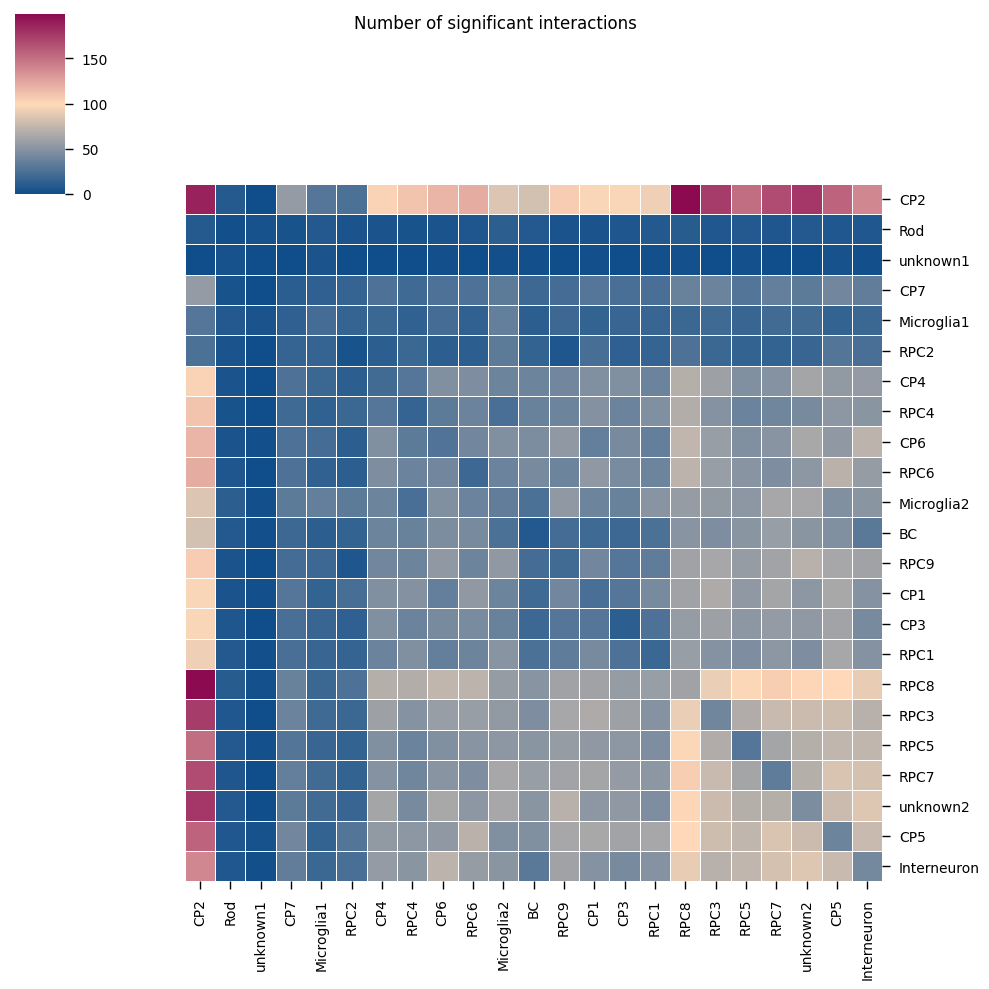

In [11]:
kpy.plot_cpdb_heatmap(
        adata = adata,
        pvals = pvals,
        celltype_key = "leiden",
        figsize = (10,10),
        title = "Number of significant interactions",
        symmetrical = True,
        #change to symmetrical and increase figure size!!
    )
#is this result just showing the clusters that show interaction? Is there a way to show the clusters that are hidden in this heat map??

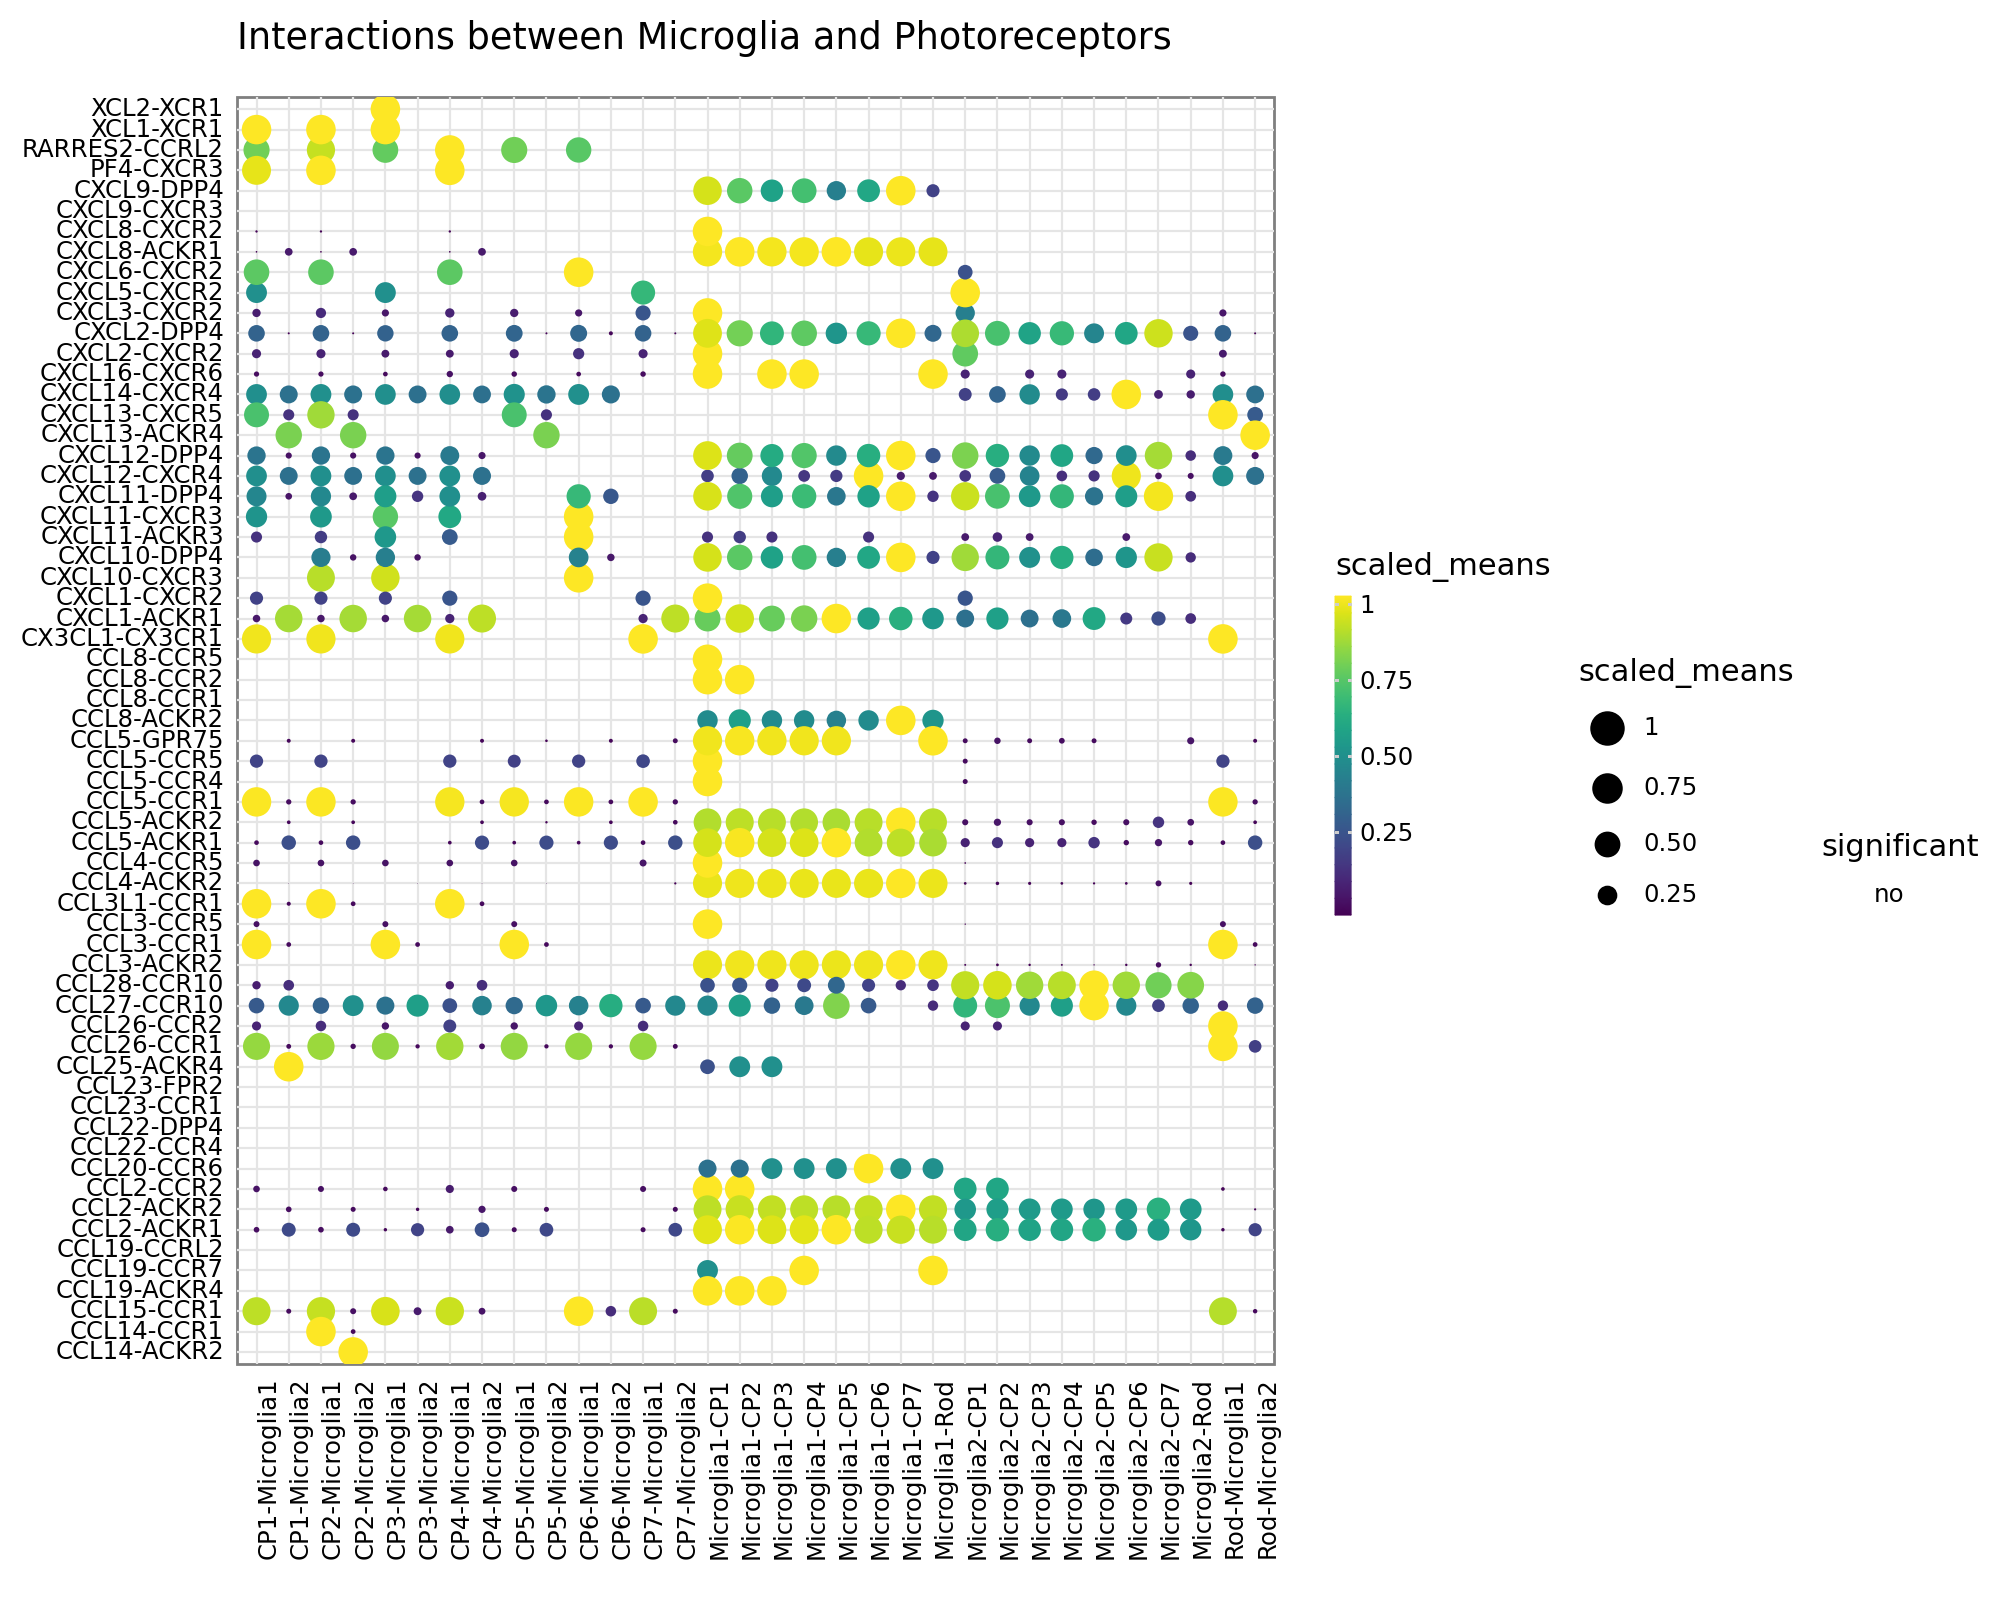

<Figure Size: (1000 x 800)>

In [24]:

kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "Microglia1|Microglia2",
    cell_type2 = "Rod|CP1|CP2|CP3|CP4|CP5|CP6|CP7", 
    means = means,
    pvals = pvals,
    celltype_key = "leiden",
    gene_family = ["chemokines"],
    figsize = (10,8),
    title = "Interactions between Microglia and Photoreceptors ",
    max_size = 6,
    highlight_size = 0.75,
    standard_scale = True
)
#glucocorticoid receptor - may demonstrate a delayed hypersensitivity reaction? - not sure significance 
#does the order of cell type - which one first show which direction the cell signalling pathway is?
#gene_family=chemokines 


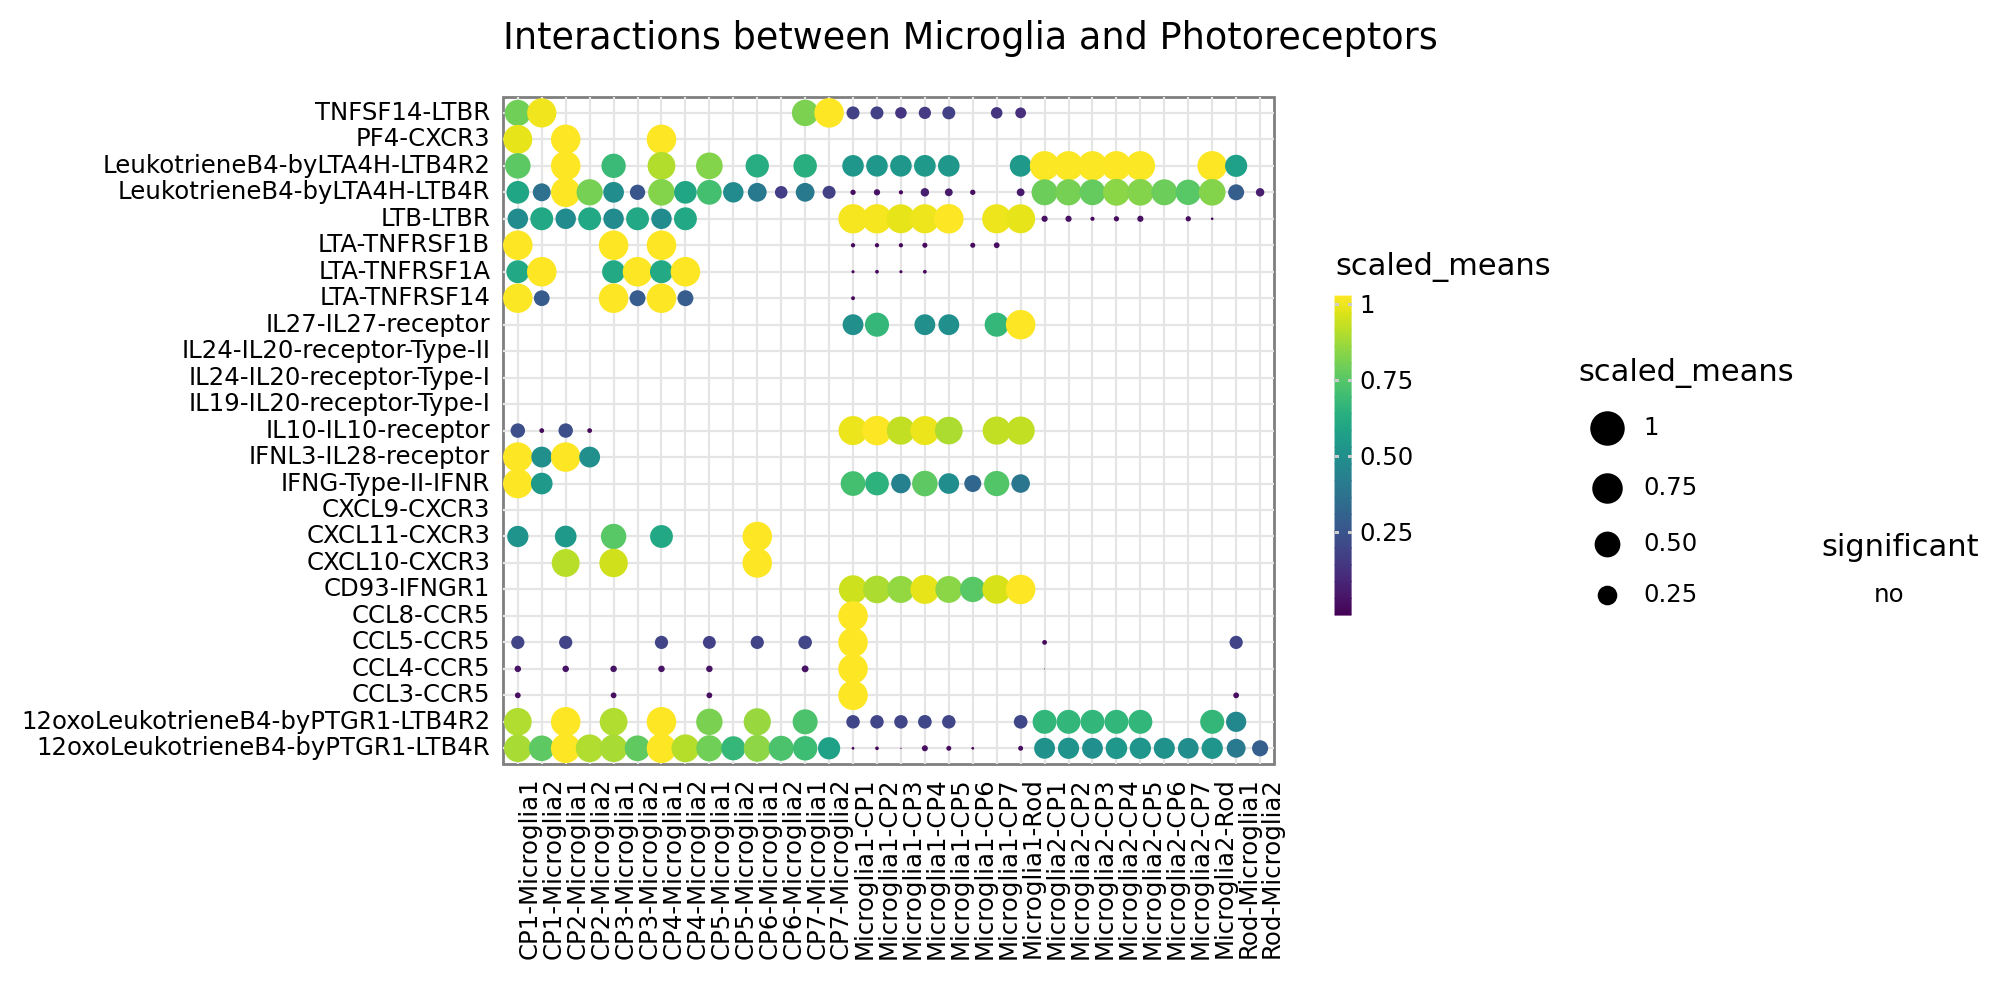

<Figure Size: (1000 x 500)>

In [23]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "Microglia1|Microglia2",
    cell_type2 = "Rod|CP1|CP2|CP3|CP4|CP5|CP6|CP7", 
    means = means,
    pvals = pvals,
    celltype_key = "leiden",
    gene_family = ["th1"],
    figsize = (10,5),
    title = "Interactions between Microglia and Photoreceptors ",
    max_size = 6,
    highlight_size = 0.75,
    standard_scale = True
)

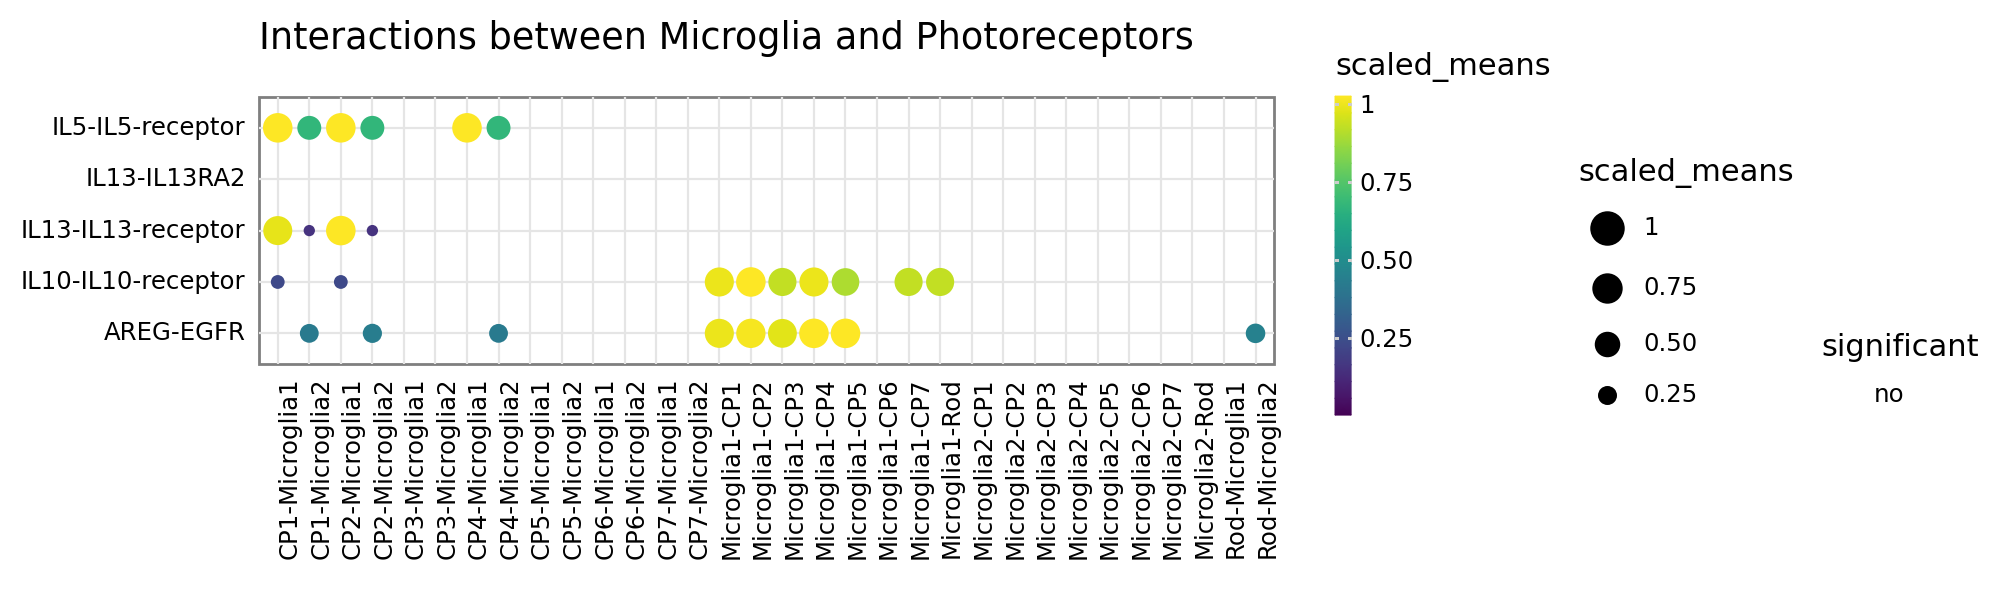

<Figure Size: (1000 x 300)>

In [33]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "Microglia1|Microglia2",
    cell_type2 = "Rod|CP1|CP2|CP3|CP4|CP5|CP6|CP7", 
    means = means,
    pvals = pvals,
    celltype_key = "leiden",
    gene_family = ["th2"],
    figsize = (10,3),
    title = "Interactions between Microglia and Photoreceptors ",
    max_size = 6,
    highlight_size = 0.75,
    standard_scale = True
)

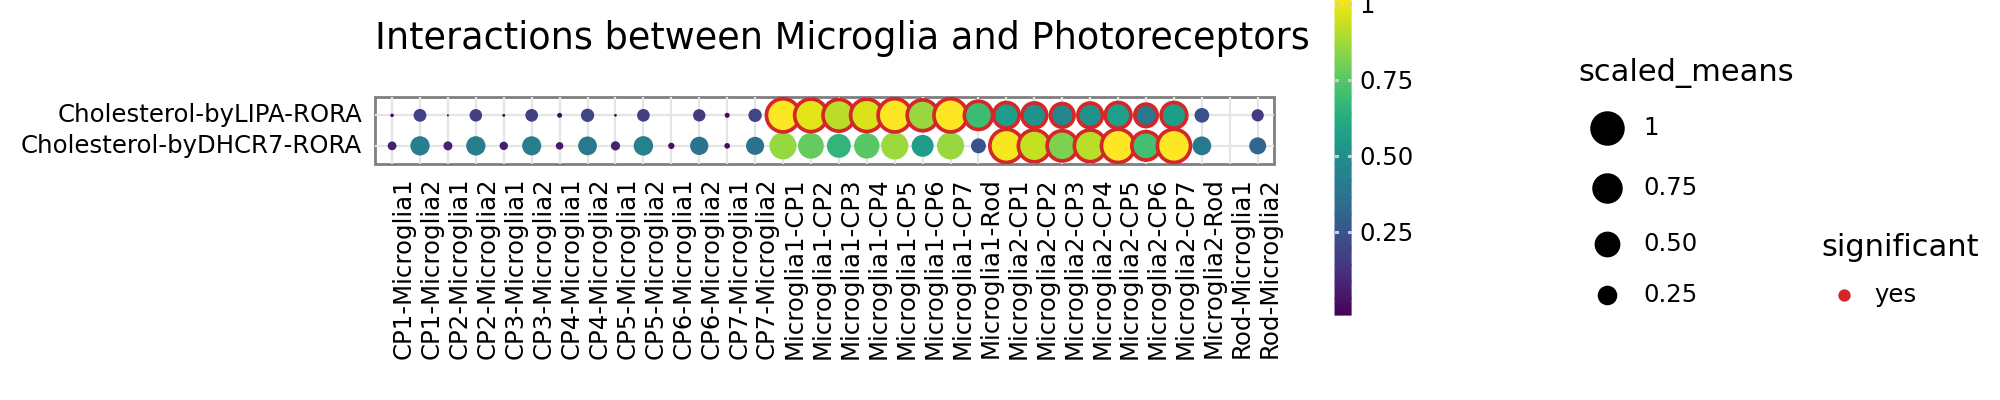

<Figure Size: (1000 x 200)>

In [38]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "Microglia1|Microglia2",
    cell_type2 = "Rod|CP1|CP2|CP3|CP4|CP5|CP6|CP7", 
    means = means,
    pvals = pvals,
    celltype_key = "leiden",
    gene_family = ["th17"],
    figsize = (10,2),
    title = "Interactions between Microglia and Photoreceptors ",
    max_size = 6,
    highlight_size = 0.75,
    standard_scale = True
)

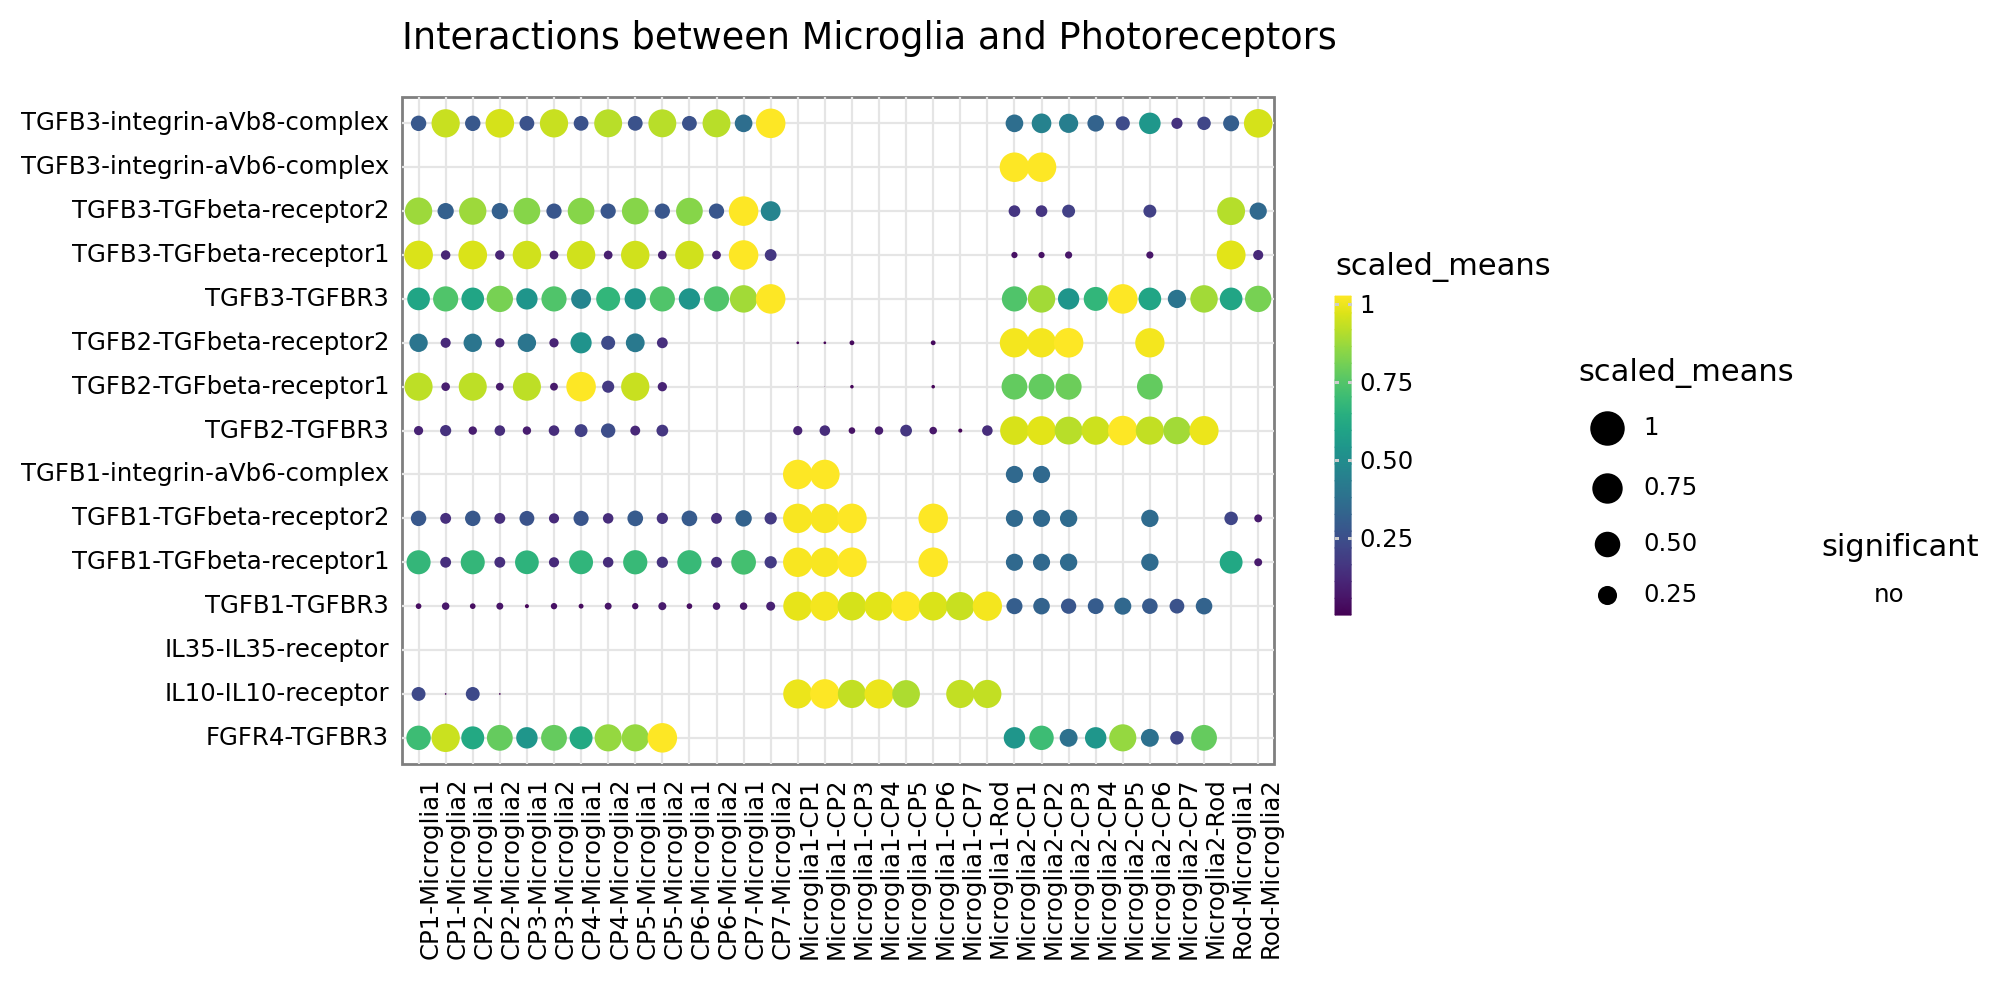

<Figure Size: (1000 x 500)>

In [40]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "Microglia1|Microglia2",
    cell_type2 = "Rod|CP1|CP2|CP3|CP4|CP5|CP6|CP7", 
    means = means,
    pvals = pvals,
    celltype_key = "leiden",
    gene_family = ["treg"],
    figsize = (10,5),
    title = "Interactions between Microglia and Photoreceptors ",
    max_size = 6,
    highlight_size = 0.75,
    standard_scale = True
)

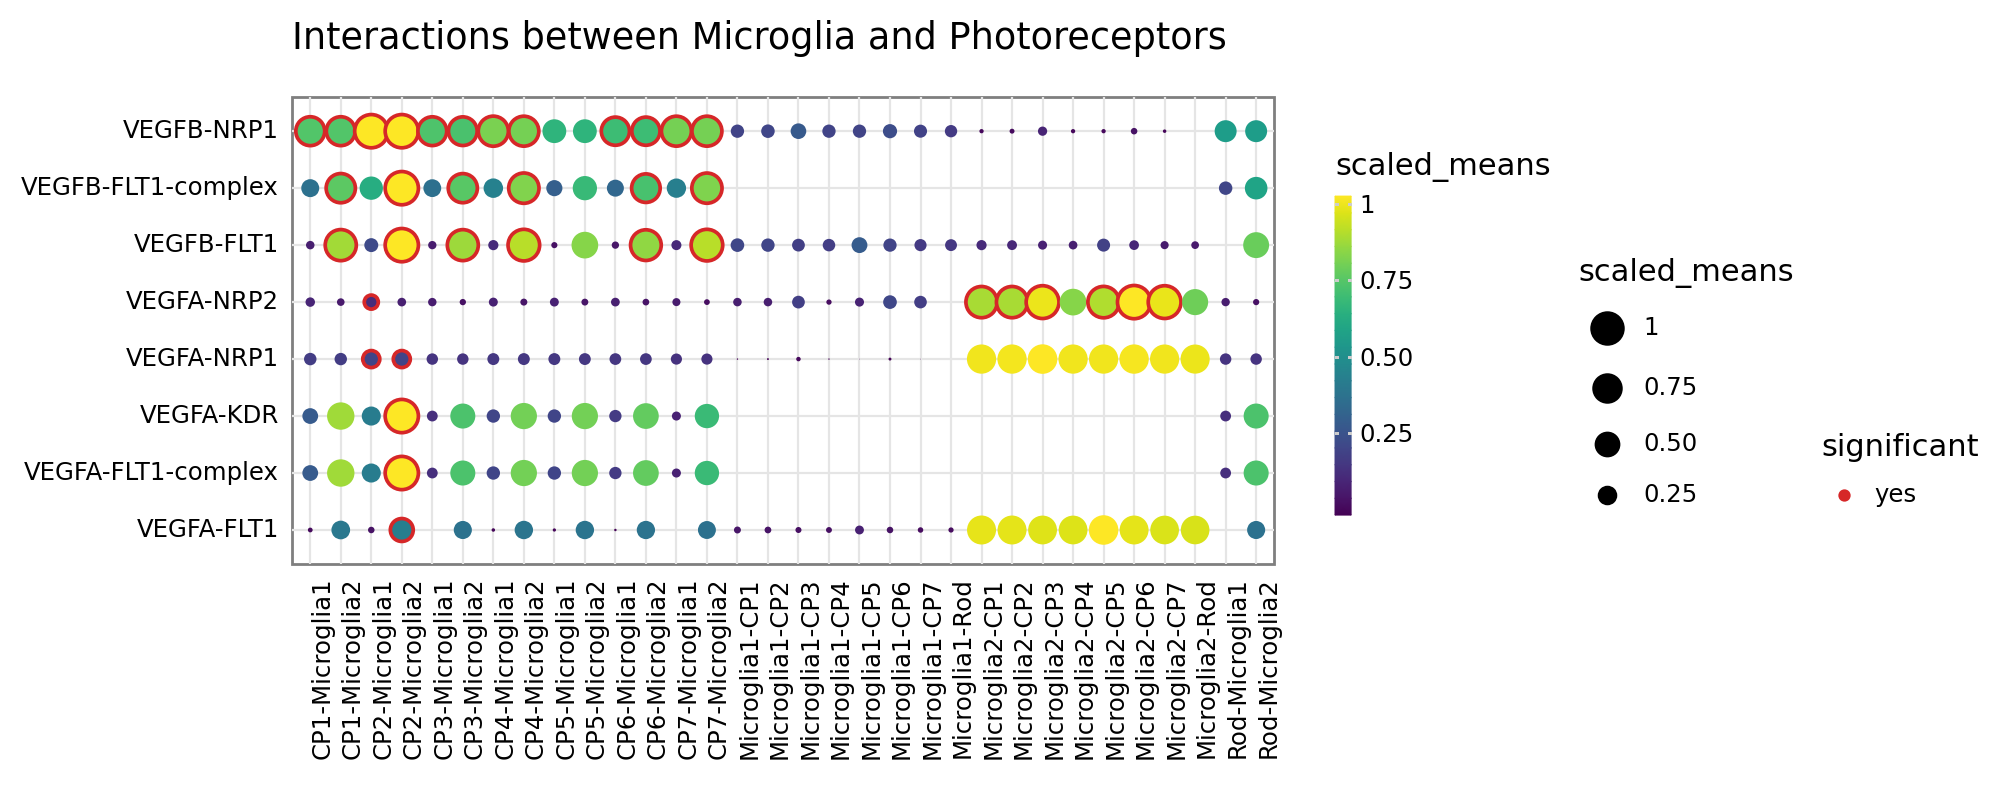

<Figure Size: (1000 x 400)>

In [65]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "Microglia1|Microglia2",
    cell_type2 = "Rod|CP1|CP2|CP3|CP4|CP5|CP6|CP7", 
    means = means,
    pvals = pvals,
    celltype_key = "leiden",
    genes = ["VEGF"],
    figsize = (10,4),
    title = "Interactions between Microglia and Photoreceptors ",
    max_size = 6,
    highlight_size = 0.75,
    standard_scale = True
)
#angiogenesis may impact healing and vision? 
#higher cellular pathways in precursors - supposedly tumour cells

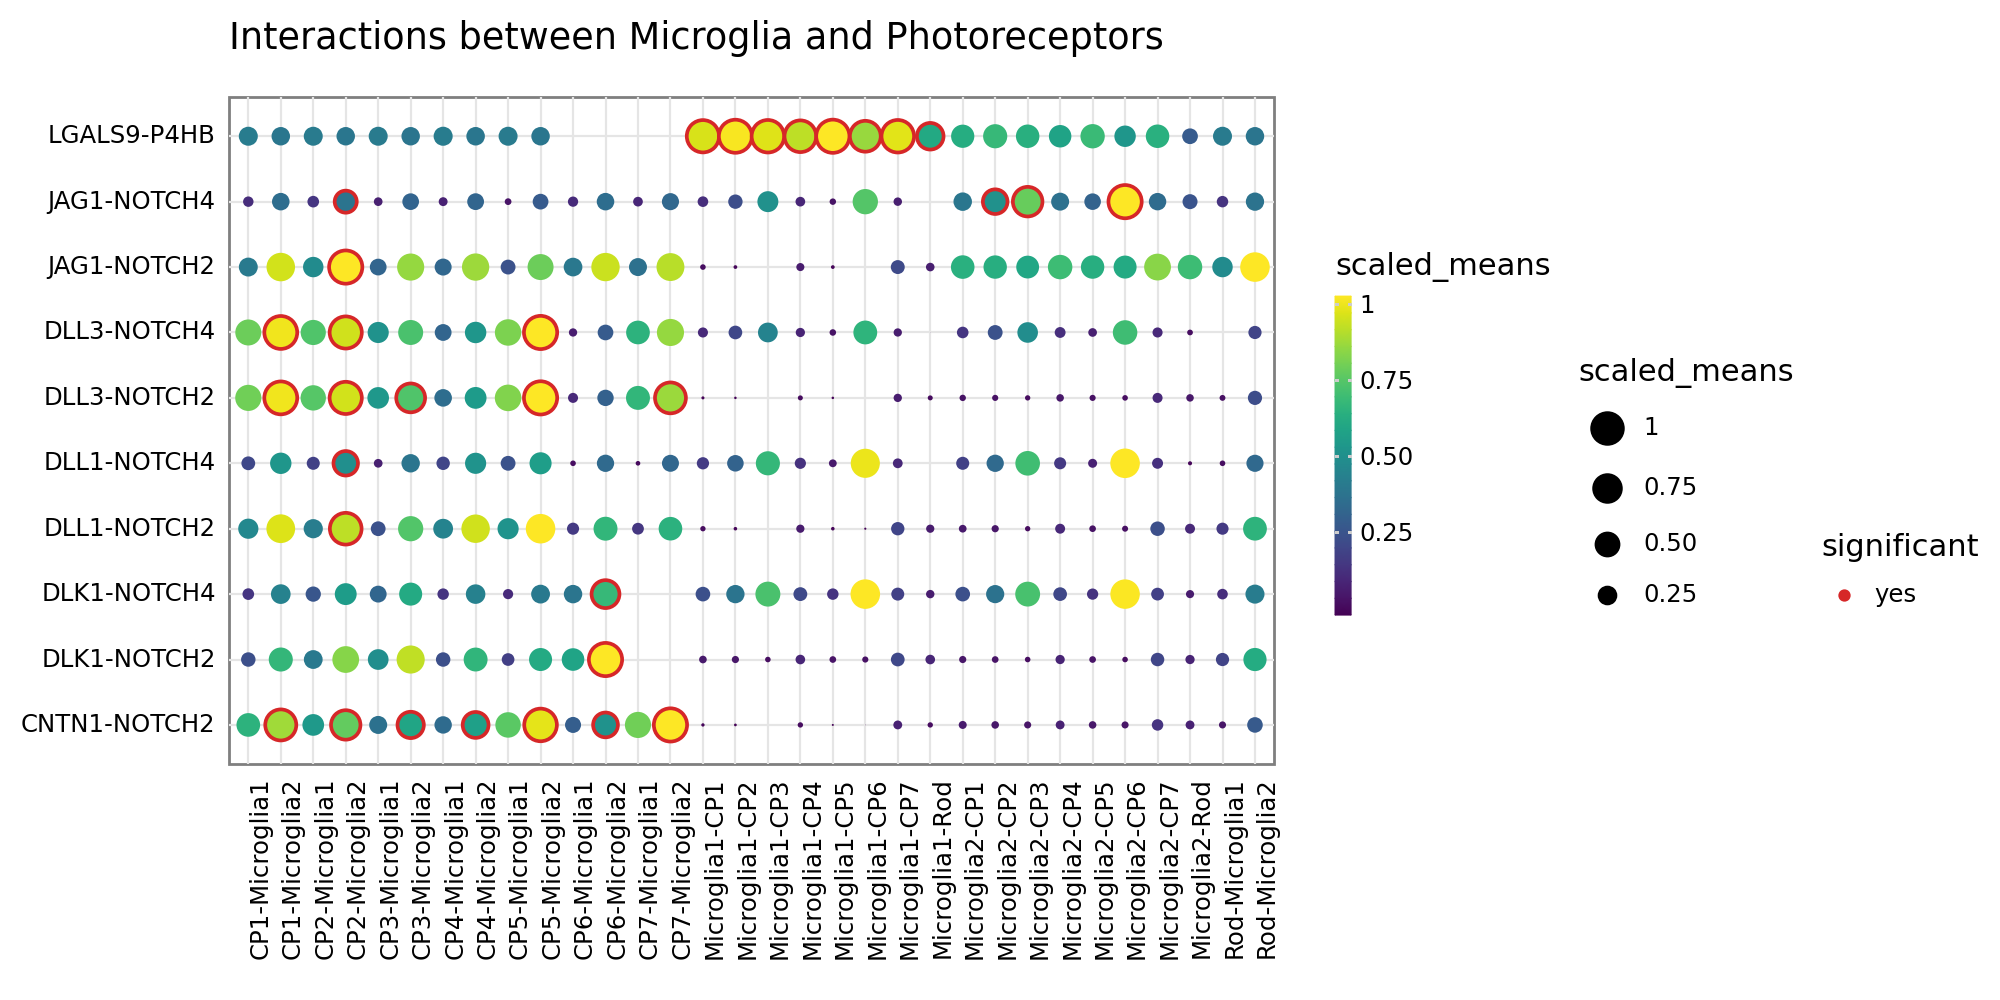

<Figure Size: (1000 x 500)>

In [87]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "Microglia1|Microglia2",
    cell_type2 = "Rod|CP1|CP2|CP3|CP4|CP5|CP6|CP7", 
    means = means,
    pvals = pvals,
    celltype_key = "leiden",
    genes = ["NOTCH", "LGAL"],
    figsize = (10,5),
    title = "Interactions between Microglia and Photoreceptors ",
    max_size = 6,
    highlight_size = 0.75,
    standard_scale = True
)